# Neural machine translation with attention

https://www.tensorflow.org/tutorials/text/nmt_with_attention

## Requirements

In [1]:
import tensorflow as tf

import unicodedata
import re
import numpy as np
import os
import io
import time
import random
import json
import operator
from collections import defaultdict

import nltk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset

In [3]:
path_to_file = 'la-en.txt'

In [4]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  #word_pairs = filterPairs(pairs)

  return zip(*pairs)

In [6]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [7]:
# BLEU score
# Translation quality metrics like BLEU
# are designed to use multiple references of a correct translation. 
# To take this into account during evaluation I combined pairs with an 
# identical source into one pair with one source and multiple targets
#
# dati due linguaggi di un rispettivo dataser, questa funzione crea un dizionario
# in cui come chiave ci sarà la frase in limgua latina e come valore ci sarà
# uyna lista con tutte le traduzioni di quella frase
def source_target_sents(lang1, lang2):
  source_to_target = {}
  for source, target in zip(lang1, lang2):
      if source in source_to_target:
          source_to_target[source].append(target)
      else:
          source_to_target[source] = [target]
      
  source_sents, target_sents = zip(*source_to_target.items())

  return source_sents, target_sents, source_to_target

In [8]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang, *other = create_dataset(path, num_examples)

  source_sents, target_sents, source_to_target = source_target_sents(inp_lang, targ_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, source_to_target

In [9]:
# Try experimenting with the size of that dataset
lines = io.open(path_to_file, encoding='UTF-8').read()
num_examples = len(lines)
input_tensor, target_tensor, inp_lang, targ_lang, source_to_target = load_dataset(path_to_file, num_examples)
print(len(input_tensor), len(target_tensor))

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

61939 61939


In [10]:
from sklearn.model_selection import train_test_split

random_state = 3

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=random_state)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.1, random_state=random_state)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test))

44595 44595 4956 4956 12388 12388


In [11]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [12]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
486 ----> petrus
15 ----> autem
4 ----> et
986 ----> iohannes
12407 ----> ascendebant
6 ----> in
789 ----> templum
10 ----> ad
867 ----> horam
4728 ----> orationis
4048 ----> nonam
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
428 ----> peter
6 ----> and
256 ----> john
52 ----> were
201 ----> going
67 ----> up
91 ----> into
5 ----> the
532 ----> temple
50 ----> at
5 ----> the
750 ----> hour
7 ----> of
784 ----> prayer
4 ----> ,
5 ----> the
2089 ----> ninth
750 ----> hour
3 ----> .
2 ----> <end>


## Hyperparameters

In [13]:
embedding_dim = 256
units = 512

TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)

TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512

train_steps_per_epoch = len(input_tensor_train)//TRAIN_BATCH_SIZE
val_steps_per_epoch = len(input_tensor_val)//VAL_BATCH_SIZE

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(VAL_BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE, drop_remainder=True)

In [14]:
example_input_batch_train, example_target_batch_train = next(iter(train_dataset))
example_input_batch_train.shape, example_target_batch_train.shape

(TensorShape([256, 35]), TensorShape([256, 37]))

In [15]:
example_input_batch_val, example_target_batch_val = next(iter(val_dataset))
example_input_batch_val.shape, example_target_batch_val.shape

(TensorShape([512, 35]), TensorShape([512, 37]))

In [16]:
example_input_batch_test, example_target_batch_test = next(iter(test_dataset))
example_input_batch_test.shape, example_target_batch_test.shape

(TensorShape([512, 35]), TensorShape([512, 37]))

## Architecture

In [17]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.25,
                                   recurrent_dropout=0.25)

  def call(self, x):
    x = self.embedding(x)
    output, state = self.gru(x)
    return output, state

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units)

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [20]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.25,
                                   recurrent_dropout=0.25)
    #self.dropout = tf.keras.layers.Dropout(0.25)
    self.fc = tf.keras.layers.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, training):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    #output = self.dropout(output, training=training)
    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_tar_size, embedding_dim, units)

In [22]:
optimizer = tf.keras.optimizers.Adam()

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Set checkpoints

In [23]:
checkpoint_dir = 'training_ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [24]:
@tf.function
def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * TRAIN_BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=True)
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [25]:
@tf.function
def valid_step(inp, targ):
  loss = 0

  enc_output, enc_hidden = encoder(inp)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * VAL_BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=False)
    loss += loss_function(targ[:, t], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss

In [26]:
from tqdm.notebook import tqdm

epochs = 0
early_stop_after = 3
early_stop_counter = 0
minimum_val_loss = 10.0

model_loss_history = {'train_loss_history' : [], 'val_loss_history' : []}

total_time_start = time.time()

for epoch in range(100):
  start = time.time()

  #enc_hidden = encoder.initialize_hidden_state()
  total_train_loss = 0
  total_val_loss = 0

  # Training
  for (batch, (inp, targ)) in tqdm(enumerate(train_dataset.take(train_steps_per_epoch)), 
                                   desc='Training epoch {}'.format(epoch+1), 
                                   total=train_steps_per_epoch):
    train_batch_loss = train_step(inp, targ)
    total_train_loss += train_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Training Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   train_batch_loss.numpy()))
  
  # Validation
  for (batch, (inp, targ)) in tqdm(enumerate(val_dataset.take(val_steps_per_epoch)), 
                                   desc='Val epoch {}'.format(epoch+1), 
                                   total=val_steps_per_epoch):
    val_batch_loss = valid_step(inp, targ)
    total_val_loss += val_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Validation Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   val_batch_loss.numpy()))

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print("<---------------------------------------->")
  print('Epoch {} Training Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                      total_train_loss / train_steps_per_epoch,
                                      total_val_loss / val_steps_per_epoch))
  
  model_loss_history['train_loss_history'].append((total_train_loss / train_steps_per_epoch).numpy())
  model_loss_history['val_loss_history'].append((total_val_loss / val_steps_per_epoch).numpy())

  print('Time taken for the epoch {} sec\n'.format(time.time() - start))

  epochs += 1

  # Early Stop
  if (total_val_loss/val_steps_per_epoch) < minimum_val_loss:
    early_stop_counter = 0
    print('The best model is found, resetting early stop counter.')
    minimum_val_loss = total_val_loss/val_steps_per_epoch
  else:
    early_stop_counter += 1
    print('No improvements for {} epochs.'.format(early_stop_counter))
    if early_stop_counter >= early_stop_after:
      print('Early stop!')
      break

print('Total Time taken for the training {} sec\n'.format(time.time() - total_time_start))

Epoch 1 Batch 0 Training Loss 3.1921
Epoch 1 Batch 100 Training Loss 1.9578



Epoch 1 Batch 0 Validation Loss 1.7894

<---------------------------------------->
Epoch 1 Training Loss 2.0230 Validation Loss 1.8673
Time taken for the epoch 376.25761699676514 sec

The best model is found, resetting early stop counter.


Epoch 2 Batch 0 Training Loss 1.9144
Epoch 2 Batch 100 Training Loss 1.7893



Epoch 2 Batch 0 Validation Loss 1.7820

<---------------------------------------->
Epoch 2 Training Loss 1.7786 Validation Loss 1.7829
Time taken for the epoch 290.66150665283203 sec

The best model is found, resetting early stop counter.


Epoch 3 Batch 0 Training Loss 1.7312
Epoch 3 Batch 100 Training Loss 1.5517



Epoch 3 Batch 0 Validation Loss 1.6754

<---------------------------------------->
Epoch 3 Training Loss 1.6889 Validation Loss 1.7249
Time taken for the epoch 288.64786028862 sec

The best model is found, resetting early stop counter.


Epoch 4 Batch 0 Training Loss 1.6064
Epoch 4 Batch 100 Training Loss 1.6426



Epoch 4 Batch 0 Validation Loss 1.6352

<---------------------------------------->
Epoch 4 Training Loss 1.6081 Validation Loss 1.6590
Time taken for the epoch 289.808940410614 sec

The best model is found, resetting early stop counter.


Epoch 5 Batch 0 Training Loss 1.5528
Epoch 5 Batch 100 Training Loss 1.5202



Epoch 5 Batch 0 Validation Loss 1.5729

<---------------------------------------->
Epoch 5 Training Loss 1.5319 Validation Loss 1.6075
Time taken for the epoch 288.0625538825989 sec

The best model is found, resetting early stop counter.


Epoch 6 Batch 0 Training Loss 1.5057
Epoch 6 Batch 100 Training Loss 1.4830



Epoch 6 Batch 0 Validation Loss 1.5395

<---------------------------------------->
Epoch 6 Training Loss 1.4592 Validation Loss 1.5550
Time taken for the epoch 290.20107412338257 sec

The best model is found, resetting early stop counter.


Epoch 7 Batch 0 Training Loss 1.4313
Epoch 7 Batch 100 Training Loss 1.4100



Epoch 7 Batch 0 Validation Loss 1.5208

<---------------------------------------->
Epoch 7 Training Loss 1.3910 Validation Loss 1.5286
Time taken for the epoch 288.85978984832764 sec

The best model is found, resetting early stop counter.


Epoch 8 Batch 0 Training Loss 1.3049
Epoch 8 Batch 100 Training Loss 1.3863



Epoch 8 Batch 0 Validation Loss 1.4926

<---------------------------------------->
Epoch 8 Training Loss 1.3306 Validation Loss 1.5001
Time taken for the epoch 290.18210458755493 sec

The best model is found, resetting early stop counter.


Epoch 9 Batch 0 Training Loss 1.2991
Epoch 9 Batch 100 Training Loss 1.3369



Epoch 9 Batch 0 Validation Loss 1.5004

<---------------------------------------->
Epoch 9 Training Loss 1.2777 Validation Loss 1.4857
Time taken for the epoch 288.7260456085205 sec

The best model is found, resetting early stop counter.


Epoch 10 Batch 0 Training Loss 1.2962
Epoch 10 Batch 100 Training Loss 1.2156



Epoch 10 Batch 0 Validation Loss 1.5223

<---------------------------------------->
Epoch 10 Training Loss 1.2294 Validation Loss 1.4764
Time taken for the epoch 290.43752551078796 sec

The best model is found, resetting early stop counter.


Epoch 11 Batch 0 Training Loss 1.1493
Epoch 11 Batch 100 Training Loss 1.1613



Epoch 11 Batch 0 Validation Loss 1.4198

<---------------------------------------->
Epoch 11 Training Loss 1.1841 Validation Loss 1.4637
Time taken for the epoch 288.52949929237366 sec

The best model is found, resetting early stop counter.


Epoch 12 Batch 0 Training Loss 1.1292
Epoch 12 Batch 100 Training Loss 1.0754



Epoch 12 Batch 0 Validation Loss 1.4665

<---------------------------------------->
Epoch 12 Training Loss 1.1398 Validation Loss 1.4597
Time taken for the epoch 290.05917954444885 sec

The best model is found, resetting early stop counter.


Epoch 13 Batch 0 Training Loss 0.9939
Epoch 13 Batch 100 Training Loss 1.0763



Epoch 13 Batch 0 Validation Loss 1.3609

<---------------------------------------->
Epoch 13 Training Loss 1.0957 Validation Loss 1.4540
Time taken for the epoch 288.7988796234131 sec

The best model is found, resetting early stop counter.


Epoch 14 Batch 0 Training Loss 0.9901
Epoch 14 Batch 100 Training Loss 1.0140



Epoch 14 Batch 0 Validation Loss 1.4722

<---------------------------------------->
Epoch 14 Training Loss 1.0509 Validation Loss 1.4417
Time taken for the epoch 290.4835252761841 sec

The best model is found, resetting early stop counter.


Epoch 15 Batch 0 Training Loss 1.0571
Epoch 15 Batch 100 Training Loss 1.0210



Epoch 15 Batch 0 Validation Loss 1.4898

<---------------------------------------->
Epoch 15 Training Loss 1.0069 Validation Loss 1.4405
Time taken for the epoch 288.405508518219 sec

The best model is found, resetting early stop counter.


Epoch 16 Batch 0 Training Loss 0.9710
Epoch 16 Batch 100 Training Loss 0.9773



Epoch 16 Batch 0 Validation Loss 1.4424

<---------------------------------------->
Epoch 16 Training Loss 0.9632 Validation Loss 1.4456
Time taken for the epoch 290.46987080574036 sec

No improvements for 1 epochs.


Epoch 17 Batch 0 Training Loss 0.8903
Epoch 17 Batch 100 Training Loss 0.8484



Epoch 17 Batch 0 Validation Loss 1.4466

<---------------------------------------->
Epoch 17 Training Loss 0.9208 Validation Loss 1.4508
Time taken for the epoch 288.1677145957947 sec

No improvements for 2 epochs.


Epoch 18 Batch 0 Training Loss 0.8929
Epoch 18 Batch 100 Training Loss 0.8480



Epoch 18 Batch 0 Validation Loss 1.4531

<---------------------------------------->
Epoch 18 Training Loss 0.8791 Validation Loss 1.4554
Time taken for the epoch 290.4337191581726 sec

No improvements for 3 epochs.
Early stop!
Total Time taken for the training 5297.219410657883 sec



In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_model_history(model_history):
  
  rows, cols = 1, 2
  fig, axs = plt.subplots(rows, cols, figsize=(15, 5))
    
  # summarize history for train_loss
  axs[0].plot(range(1, len(model_history['train_loss_history'])+1), 
              model_history['train_loss_history'], 
              color = 'blue')
  axs[0].scatter(range(1, len(model_history['train_loss_history'])+1), 
                 model_history['train_loss_history'], 
                 color = 'blue')
  axs[0].set_title('Train Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_xticks(np.arange(epochs+1))
  axs[0].legend(['train'], loc='best')



  # summarize history for val_loss
  axs[1].plot(range(1, len(model_history['val_loss_history'])+1), 
              model_history['val_loss_history'], 
              color = 'red')
  axs[1].scatter(range(1, len(model_history['val_loss_history'])+1), 
                 model_history['val_loss_history'], 
                 color = 'red')
  axs[1].set_title('Val Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_xticks(np.arange(epochs+1))
  axs[1].legend(['val'], loc='best')

  plt.show()

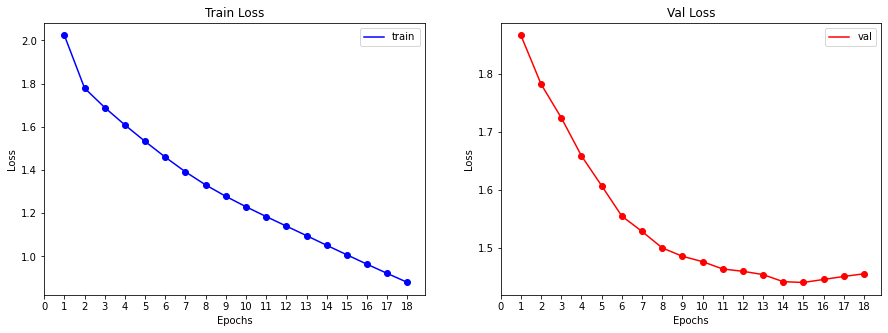

In [28]:
plot_model_history(model_loss_history)

## Translate

In [29]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')

  inputs = tf.convert_to_tensor(inputs)
  result = ''
  enc_out, enc_hidden = encoder(inputs)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out,
                                                         training=False)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [30]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [31]:
def translate(sentence, with_plot=True):
  result, sentence, attention_plot = evaluate(sentence)
  if(with_plot):
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  
  return result, sentence, attention_plot

## Restore checkpoint

In [32]:
model = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Metrics

### Sentence BLEU score

In [33]:
#trasforma il tensore in frase
def tensor2sentence(lang, tensor):
  sentence = ""
  for t in tensor:
    if t!=0:
      sentence += lang.index_word[t] + " "
  return sentence

In [34]:
# questa funzione dato un insieme in input ed un dizionario,
# mi trasforma tutti i tensori di tale insieme in un insieme
# di frasi corrispondenti
def tensor2set(tensor_set, lang):
  list = []
  for tensor in tensor_set:
    sentence = tensor2sentence(lang, tensor)
    list.append(sentence)
  
  return list

In [35]:
source_sents_test = tensor2set(input_tensor_test, inp_lang)

In [36]:
# poichè nel dataset ci sono molte frasi che hanno diverse traduzioni,
# questa funzione trova tutte le traduzioni di una determinata frase
# nel dizionario passato come parametro
def multiple_target(sentence, dict):
  targets = []
  for key, value in dict.items():
    if key == sentence and len(value) > 1:
      targets += (value)
  return targets

In [37]:
# questa funzione sceglie casualmente una frase dal sents_set,
# assicurandosi che tale frase abbia almeno 4 traduzioni diverse
# nel dizionario source_target_sents
def sent_random_choice(sents_set, source_to_target):

  full_sent = random.choice(source_sents_test).strip()
  targets = multiple_target(full_sent, source_to_target)

  if len(targets) > 3:
    print(full_sent)
    print(len(targets))
    return full_sent, targets
  else:
    return sent_random_choice(sents_set, source_to_target)

In [38]:
def clean_sentence(sentence):
  sentence = sentence.lstrip("<start>")
  sentence = sentence.rstrip("<end>")
  sentence = sentence.strip()
  sentence = re.sub(r"[^a-zA-Z]+", " ", sentence)

  return sentence

In [79]:
full_sent, targets = sent_random_choice(source_sents_test, source_to_target)

<start> hircumque pro peccato <end>
24


In [80]:
short_sent = clean_sentence(full_sent)

In [ ]:
translation, sentence, attention_plot = translate(short_sent)

In [42]:
def clean_corpus_references(targets, split=False):
  references = []
  for t in targets:
    t = clean_sentence(t)
    if split == True:
      references.append(t.split())
    else:
      references.append(t)

  return references

In [82]:
references = clean_corpus_references(targets, split=True)

In [44]:
def clean_translation(translation):
  translation = translation.rstrip("<end>")
  translation = re.sub(r"[^a-zA-Z]+", " ", translation)
  translation = translation.strip()

  return translation

In [83]:
translation = clean_translation(translation)

In [84]:
hypothesis = list(translation.split())

While matching sentences you can choose the number of words you want the model to match at once.
You can also choose for words to be matched one at a time (1-gram), or to match words in pairs (2-gram) or triplets (3-grams)...


BLEU non è mai stato creato pensando al confronto del livello di frase, ecco una bella discussione: https://github.com/nltk/nltk/issues/1838 Molto probabilmente, vedrai l'avviso quando hai frasi molto brevi

In [85]:
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu

print('Individual 1-gram: %f' % sentence_bleu(references, hypothesis, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.875000
Individual 2-gram: 0.857143
Individual 3-gram: 0.833333
Individual 4-gram: 0.800000


By default the sentence_bleu() function calculates the cumulative 4-gram BLEU score, also called BLEU-4. The weights for BLEU-4 are as follows :

The default BLEU calculates a score for up to 4-grams using uniform weights (this is called BLEU-4), where each weight is 1/4.

In [86]:
sentence_score = sentence_bleu(references, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU-4: %f' % sentence_score)

BLEU-4: 0.840896


BLEU score problems:

* It doesn’t consider meaning
* It doesn’t directly consider sentence structure
* It doesn’t handle morphologically rich languages well
* It doesn’t map well to human judgements

You can use the smoothing functions in https://github.com/alvations/nltk/blob/develop/nltk/translate/bleu_score.py#L425 to overcome short sentences.



This is an implementation of the smoothing techniques for segment-level BLEU scores that was presented in Boxing Chen and Collin Cherry (2014) A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU. In WMT14.
http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf

In [49]:
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method4
smoothie_score = bleu(references, hypothesis, smoothing_function=smoothie)
print('SMOOTHIE SCORE: %f' % smoothie_score)

SMOOTHIE SCORE: 0.000000


### Corpus BLEU score

http://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.corpus_bleu

Instead of averaging the sentence level BLEU scores (i.e. marco-average precision), the original BLEU metric (Papineni et al. 2002) accounts for the micro-average precision (i.e. summing the numerators and denominators for each hypothesis-reference(s) pairs before the division).

In [50]:
def prepare_corpus(source_sents_test, source_target_sents):
  list_of_references = []
  hypothesis = []
  for sent in source_sents_test:
    targets = multiple_target(sent.strip(), source_target_sents)
    if len(targets) > 3:
      full_sent = clean_sentence(sent)
      translation, sentence, attention_plot = translate(full_sent, 
                                                        with_plot=False)
      
      translation = translation.rstrip("<end>").strip()
      translation = re.sub(r"[^a-zA-Z]+", " ", translation)
      targets = clean_corpus_references(targets, split=True)
      list_of_references.append(targets)
      hypothesis.append(translation.split())
  
  return hypothesis, list_of_references

In [51]:
hypothesis, list_of_references = prepare_corpus(source_sents_test, source_to_target)

In [52]:
from nltk.translate.bleu_score import corpus_bleu

corpus_score = corpus_bleu(list_of_references, hypothesis)
print('CORPUS BLEU SCORE: %f' % corpus_score)

CORPUS BLEU SCORE: 0.311283


## Attention Weights

Input: <start> nondum venit hora mea . <end>
Predicted translation: i have to my father in my father . <end> 


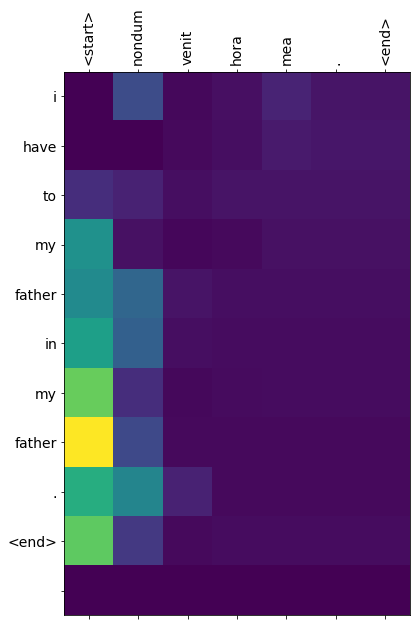

In [53]:
short_sent = 'Nondum venit hora mea.'
outputs, inputs, attention_plot = translate(short_sent)
#inputs = inputs.lstrip("<start>").rstrip("<end>").strip()
#outputs = outputs.strip().rstrip("<end>").strip()

In [54]:
# questa funzione costruisce un dizionario in cui per ogni chiave (parola spagnola)
# si ha una coppia chiave-valore rappresentata dalla parola inglese e dal 
# rispettivo peso di attention
def translate2attn(result, sentence, attention_plot):
  translation_weights = {}
  for i, token in enumerate(sentence.split()):
    translation_weights[token] = {}
    for j, tkn in enumerate(result.split()):
      translation_weights[token][tkn] = attention_plot[j][i]
  return translation_weights

In [55]:
def attn2json(translation_weights):
  with open('attention_weights.json', 'w') as fp:
    json.dump(translation_weights, fp)

In [56]:
# dato il dizionario, per ogni chiave rappresentata dalla parola in inglese
# prende il massimo in base al peso di attention, con la rispettiva
# parola in latino
def translation_prediction(translation_weights):
  translation_prediction = {}
  for key, value in translation_weights.items():
    maximum = max(value, key=value.get)
    translation_prediction[key] = maximum

  return translation_prediction

Input: <start> nondum venit hora mea . <end>
Predicted translation: i have to my father in my father . <end> 


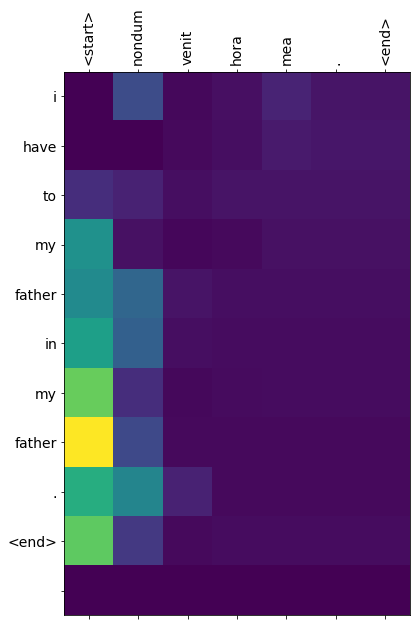

In [57]:
_ = translate(short_sent)

In [58]:
translation_weights = translate2attn(outputs, inputs, attention_plot)
predictions = translation_prediction(translation_weights)

print(predictions)

{'<start>': 'father', 'nondum': '.', 'venit': '.', 'hora': 'to', 'mea': 'i', '.': 'have', '<end>': 'have'}


## StanfordNERTagger

In [59]:
!pip install nltk

In [60]:
!wget 'https://nlp.stanford.edu/software/stanford-ner-4.2.0.zip'
!unzip stanford-ner-4.2.0.zip

--2021-03-19 16:31:14--  https://nlp.stanford.edu/software/stanford-ner-4.2.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180437064 (172M) [application/zip]
Saving to: ‘stanford-ner-4.2.0.zip’

stanford-ner-4.2.0. 100%[===================>] 172.08M  6.45MB/s    in 22s     

2021-03-19 16:31:37 (7.80 MB/s) - ‘stanford-ner-4.2.0.zip’ saved [180437064/180437064]

Archive:  stanford-ner-4.2.0.zip
   creating: stanford-ner-2020-11-17/
   creating: stanford-ner-2020-11-17/lib/
  inflating: stanford-ner-2020-11-17/lib/jollyday-0.4.9.jar  
  inflating: stanford-ner-2020-11-17/lib/stanford-ner-resources.jar  
  inflating: stanford-ner-2020-11-17/lib/joda-time.jar  
  inflating: stanford-ner-2020-11-17/stanford-ner-4.2.0.jar  
  inflating: stanford-ner-2020-11-17/NERDemo.java  
  inflating: stanford-ner-2020-11-17/LICENSE.txt  
  inflati

In [61]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [62]:
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

jar = "stanford-ner-2020-11-17/stanford-ner-4.2.0.jar"
model = "stanford-ner-2020-11-17/classifiers/" 
st_3class = StanfordNERTagger(model + "english.all.3class.distsim.crf.ser.gz", jar, encoding='utf8')
st_4class = StanfordNERTagger(model + "english.conll.4class.distsim.crf.ser.gz", jar, encoding='utf8')
st_7class = StanfordNERTagger(model + "english.muc.7class.distsim.crf.ser.gz", jar, encoding='utf8')

/usr/local/lib/python3.7/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [63]:
# collego le parole in inglese con la parola di origine in latino,
# insieme al suo relativo tag
def source2translation(classified_text, predictions):
  source_to_translation = []
  for lat_word, en_word in predictions.items():
    for key, tag in classified_text:
      if en_word == key:
        source_to_translation.append((lat_word, tag))
  return source_to_translation

In [64]:
def get_key_dict(word, dict):
  my_list = []
  for key in dict:
    if dict[key] == word:
      my_list.append(key)
  return my_list

In [65]:
def get_tag_list(key, list):
    for token, tag in list:
        if token == key:
            return tag

In [66]:
# uniformo il risultato secondo il formato dello stanford ner tagger
def translation_to_ner_predictions(predictions, line, classified_text):
  classified_list = []

  for word in line.split():
    key_list = get_key_dict(word, predictions)
    for key in key_list:
      tag = get_tag_list(key, classified_text)
      classified_list.append((word, tag))

  return classified_list

In [ ]:
for line in latin_text_lines[: 10000]:

  # pulisco la frase
  line = preprocess_sentence(line)
  line = line.lstrip("<start>").rstrip("<end>")
  print("LINE {}: {}".format(i, line))

  # traduco la frase in inglese
  translation, sentence, attention_plot = translate(line, with_plot=False)
  print("TRANSLATION: " + translation)

  # pulisco la frase in latino
  # pulisco la traduzione
  translation_ner = translation.strip().rstrip("<end>").strip()
  
  # taggo la traduzione con il NER tagger di stanford
  tokenized_text = word_tokenize(translation_ner)
  classified_text = st_3class.tag(tokenized_text)
  print ("NER_TRANSLATION: {}".format(classified_text))

  # ottengo una lista con le parole in latino che corrispondono alle parole 
  # in inglese taggate dal ner tagger di stanford
  translation_weights = translate2attn(translation, sentence, attention_plot)
  predictions = translation_prediction(translation_weights)
  source_to_translation = source2translation(classified_text, predictions)
  print ()
  print("PREDICTIONS: {}".format(predictions))
  print("STANFORD_NER: {}".format(source_to_translation))

  print ("="*10)